In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import latexify
import sympy as sp
from scipy.special import expit, logit
from sklearn.linear_model import RidgeCV
from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier
from causalml.dataset import synthetic_data

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [2]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(6,6))
    nx.draw(
    G=graph,
    node_color='grey',
    node_size=5000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=10,
    pos=nx.circular_layout(graph)
    )

# Simple Problem

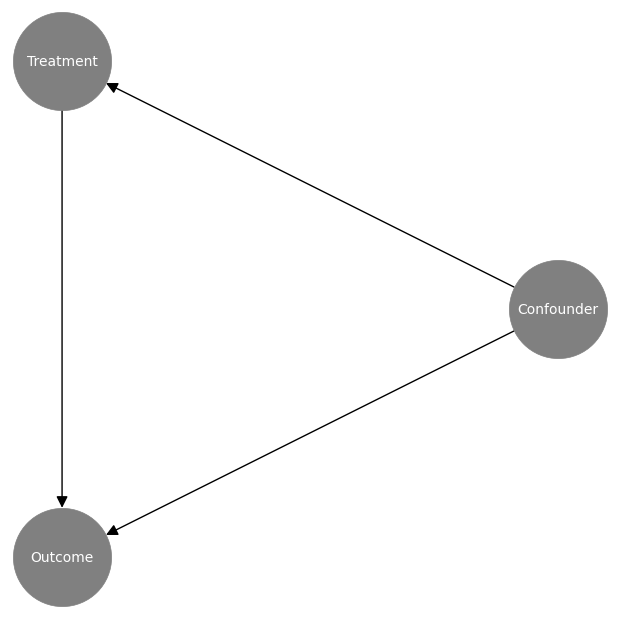

In [3]:
# Create node lookup variables
node_lookup = {0: 'Confounder',
               1: 'Treatment',
               2: 'Outcome'                                                                                       
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Confounder -> Treatment
graph_actual[0, 2] = 1.0 # Confounder -> Outcome
graph_actual[1, 2] = 1.0 # Treatment -> Outcome
     
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

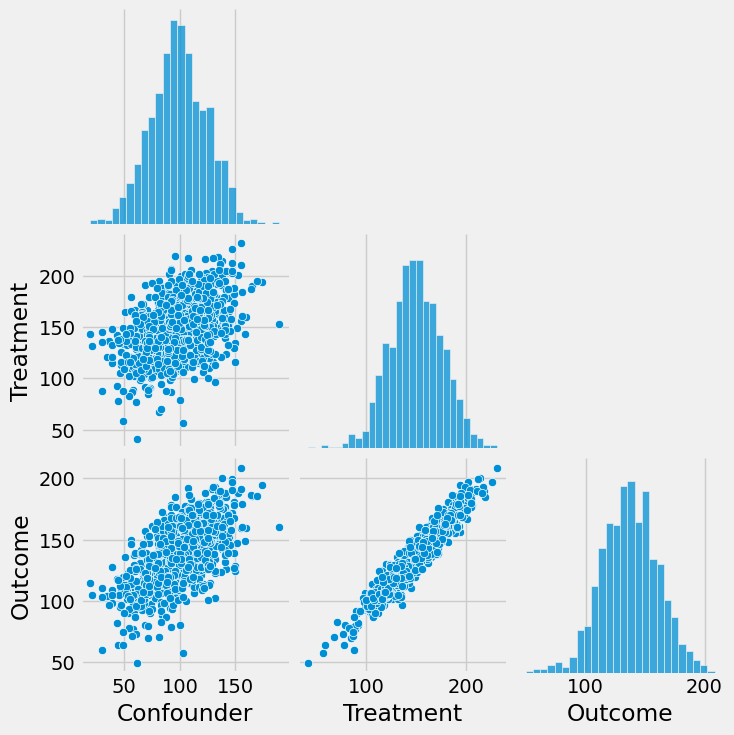

In [4]:
np.random.seed(123)

# Create dataframe with a confounder, treatment and outcome
df = pd.DataFrame(columns=['Confounder', 'Treatment', 'Outcome'])
df['Confounder'] = np.random.normal(loc=100, scale=25, size=1000)
df['Treatment'] = np.random.normal(loc=100, scale=25, size=1000) + 0.50 * df['Confounder']
df['Outcome'] = 0.25 * df['Confounder'] + 0.75 * df['Treatment'] + np.random.normal(loc=0, scale=5, size=1000)

sns.pairplot(df, corner=True)

# Linear regression

In [32]:
# Some math symbols are converted automatically.
@latexify.expression(use_math_symbols=True)
def y(X, T):
  y = beta * X + tau * T + epsilon
  return y

y

In [5]:
# Set target and features
y = df['Outcome']
X = df[['Confounder', 'Treatment']]

# Train linear regression model 
model = RidgeCV()
model = model.fit(X, y)

# Extract the treatment coefficient
ate_lr = round(model.coef_[1], 2)

print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.75


# FWL

In [6]:
# Set treatment, outcome and confounder samples
treatment = df['Treatment'].to_numpy().reshape(-1,1)
outcome = df['Outcome'].to_numpy().reshape(-1,1)
confounder = df['Confounder'].to_numpy().reshape(-1,1)

# Train treatment model and calculate residuals
treatment_model = RidgeCV()
treatment_model = treatment_model.fit(confounder, treatment)
treatment_pred = treatment_model.predict(confounder)
treatment_residuals = treatment - treatment_pred

# Train outcome model and calculate residuals
outcome_model = RidgeCV()
outcome_model = outcome_model.fit(confounder, outcome)
outcome_pred = outcome_model.predict(confounder)
outcome_residuals = outcome - outcome_pred

# Train residual model and calculate average treatment effect
final_model = RidgeCV()
final_model = final_model.fit(treatment_residuals, outcome_residuals)
ate_fwl = round(final_model.coef_[0][0], 2)

print(f'The average treatment effect using the FWL approach is: {ate_fwl}')

The average treatment effect using the FWL approach is: 0.75


# DML

In [7]:
# Train DML model
dml = LinearDML(discrete_treatment=False)
dml.fit(df['Outcome'].to_numpy().reshape(-1,1), T=df['Treatment'].to_numpy().reshape(-1,1), X=None, W=df['Confounder'].to_numpy().reshape(-1,1))

# Calculate average treatment effect
ate_dml = round(dml.ate()[0], 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.75


# Complex Problem

|Variable|Description|
|-|-|
|x01|days_since_last_order|
|x02|order_count_last_07_days|
|x03|order_count_last_30_days|
|x04|order_count_last_180_days|
|x05|order_value_last_07_days|
|x06|order_value_last_30_days|
|x07|order_value_last_180_days|
|x08|age|
|x09|gender|
|x10|city|


In [8]:
np.random.seed(123)

# Set number of observations
n=100000

# Set number of features
p=10

# Create features
X = np.random.uniform(size=n * p).reshape((n, -1))

# Nuisance parameters
b = (
    np.sin(np.pi * X[:, 0] * X[:, 1])
    + 2 * (X[:, 2] - 0.5) ** 2
    + X[:, 3]
    + 0.5 * X[:, 4]
    + X[:, 5] * X[:, 6]
    + X[:, 7] ** 3
    + np.sin(np.pi * X[:, 8] * X[:, 9])
)

# Create binary treatment
T = np.random.binomial(1, expit(b))

# Set treatment effect
tau = 0.75

# Calculate outcome
y = b + T * tau + np.random.normal(size=n)

In [22]:
# Some math symbols are converted automatically.
@latexify.expression(use_math_symbols=True)
def y():
  y = sin(pi * x1 * x2) + 2 * (x3 - 0.5) **2 + x4 + 0.5 * x5 + x6 * x7 + x8 **3 + sin(pi * x9 * x10) + tau * T + epsilon
  return y

y

In [9]:
np.random.seed(123)

# Train DML model using flexible stage 1 models
dml = LinearDML(model_y=LGBMRegressor(), model_t=LGBMClassifier(), discrete_treatment=True)
dml.fit(y, T=T, X=None, W=X)

# Calculate average treatment effect
ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

[LightGBM] [Info] Number of positive: 45387, number of negative: 4613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.907740 -> initscore=2.286347
[LightGBM] [Info] Start training from score 2.286347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 10
[LightGBM] [Info] Start training from score 3.146676
[LightGBM] [Info] Number of positive: 45387, number of negative: 4613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 se

In [10]:
print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.74


In [11]:
# Append features and treatment
X_T = np.append(X, T.reshape(-1, 1), axis=1)

# Train linear regression model 
model = RidgeCV()
model = model.fit(X_T, y)
y_pred = model.predict(X_T)

# Extract the treatment coefficient
ate_lr = round(model.coef_[-1], 2)

print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.85


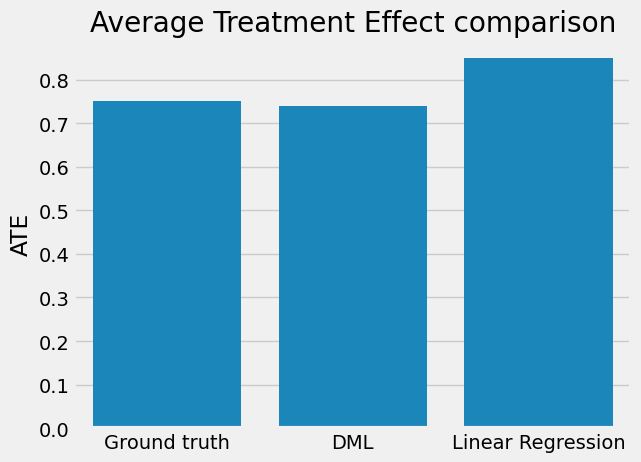

In [12]:
# Plot comparison of results
categories = ['Ground truth', 'DML', 'Linear Regression']
sns.barplot(x=categories, y=[tau, ate_dml, ate_lr])
plt.ylabel('ATE')
plt.title('Average Treatment Effect comparison')
plt.show()